# Pancake Swap Prediction Bot
Ref Source: https://medium.com/@pierreia/make-an-ai-powered-bot-for-pancakeswap-prediction-part-1-ddc66819ad91


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from binance.client import Client
import matplotlib.pyplot as plt

In [2]:
api = {'key':'mLSxbjwzPSlakxzOjqOiKg7cdlRWuyzhEwsrCj7WuxCbzCjrMstBmhIEBid55qtk','secret':'dvlIfurf3ckuVM8y1WEzkqtB6WB83Ty0x79dz9igNGqlitqlQQM4nQDv75l51Z6E'}

In [3]:
lenght_data = "7 day" #We get 1 minute data for the last 7 days
client = Client(api['key'], api['secret'])
klines = client.get_historical_klines("BNBUSDT", Client.KLINE_INTERVAL_1MINUTE, lenght_data + " UTC")
klines_close = [kline[1] for kline in klines]  # close value is column 1

In [4]:
X_l = []
Y_l = []
lookback = 10 #our lookback is 10 last prices

for i in range(lookback,len(klines_close)-lookback):
    if klines_close[i] < klines_close[i+5]:
        Y_l.append(1)
    else:
        Y_l.append(0)
    X_l.append(klines_close[i-lookback:i])


In [5]:
X = np.array(X_l) #We convert our data into numpy arrays
Y = np.array(Y_l)

In [6]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [7]:
t = int(len(X)*0.8) #we keep 80% of the data for the training
X_train, X_test = scaler.transform(X[:t]), scaler.transform(X[t:])
Y_train, Y_test = Y[:t].copy(), Y[t:].copy()

In [8]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [9]:
log_rfc = RandomForestClassifier(max_depth=20, n_estimators=500)
log_svm = SVC(probability=True)
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),n_estimators=1000)
gbrc = GradientBoostingClassifier(max_depth=20, n_estimators=1000)

In [10]:
model = log_rfc

In [11]:
model.fit(X_train,Y_train)
Y_train_pred = model.predict(X_train)
Y_pred = model.predict(X_test)

In [12]:
print("Accuracy: " + str(accuracy_score(Y_pred,Y_test)))
#scores = cross_val_score(model,X_train,Y_train,cv=10)

Accuracy: 0.5213717693836978


In [13]:
b = 1 #Start balance for RFC Strategy
bet = 0.1 #Amount of bet
fee = 0.001 #Transaction fees
br = 1 #Start balance for Random Strategy

In [14]:
l_b = []
l_br = []
for i in range(len(Y_test)):
    odd = np.random.randint(1200,3000)/1000
    rand = np.random.randint(0,2)
    if Y_pred[i] == Y_test[i]:
        b += (odd-1)*bet - 2*fee
    else:
        b -= bet - fee

    if 0 == Y_test[i]:
        br += (odd-1)*bet - 2*fee
    else:
        br -= 1 - fee
    l_b.append(b)
    l_br.append(br)

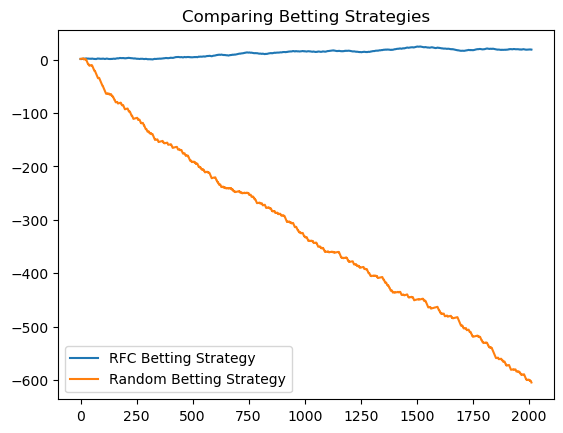

In [15]:
rfc_line, = plt.plot(l_b,label='RFC Betting Strategy')
random_line, = plt.plot(l_br,label="Random Betting Strategy")
plt.legend(handles=[rfc_line, random_line])
plt.title("Comparing Betting Strategies")
plt.show()

In [35]:
modelX = None
scalerX = None
trained = False
api = {'key':'mLSxbjwzPSlakxzOjqOiKg7cdlRWuyzhEwsrCj7WuxCbzCjrMstBmhIEBid55qtk','secret':'dvlIfurf3ckuVM8y1WEzkqtB6WB83Ty0x79dz9igNGqlitqlQQM4nQDv75l51Z6E'}

def get_prices(window):
    client = Client(api['key'], api['secret'])
    klines = client.get_historical_klines("BNBUSDT", Client.KLINE_INTERVAL_1MINUTE, window + " UTC")
    klines_close = [kline[1] for kline in klines]  # la colomne des valeurs de clotures est la colonne 1

    return klines_close
    
def train():
    global modelX
    global scalerX
    global trained
    
    print("Creating model...")
    modelX = RandomForestClassifier(max_depth=20, n_estimators=500)
    print("Scraping prices...")

    closep = get_prices("3 day")
    X_l = []
    Y_l = []

    length = 5
    for i in range(length, len(closep) - length):
        if closep[i] < closep[i + length]:
            Y_l.append(1)
        else:
            Y_l.append(0)
        X_l.append(closep[i - length:i])

    X = np.array(X_l)
    Y = np.array(Y_l)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    scalerX = scaler

    print('Training model...')
    modelX.fit(X,Y)
    print("Model trained")
    
    trained = True
    
def predict():
    global modelX
    global scalerX
    global trained
    
    # X = data[id]["last prices"]
    last_prices_brut = get_prices("5 minute")
    while len(last_prices_brut) < 5:
        sleep(1)
        print("Error while scraping prices")
        last_prices_brut = get_prices("5 minute")
    last_prices = scalerX.transform(np.array([last_prices_brut]))

    X = last_prices
    
    prediction = modelX.predict(X)[0]
    if prediction == 0:
        print("Prediction : Down ")
    else:
        print("Prediction : Up ")


In [36]:
trained

False

In [37]:
train()

Creating model...
Scraping prices...
Training model...
Model trained


In [38]:
trained

True

In [39]:
predict()

Prediction : Up 
